### Notebook 2: Balanced Training Data: 300x 

* Model trained on [equal number of GTcons training examples](#equal)
* Homozygous Reference [0] : 120
* Heterozygous Variant [1] : 120
* Homozygous Variant   [2] : 120

Summary
------
* poor precision score post balanced labels: [0.69](#poor_score1)
* low/incorrect [predictions](#predictions)

In [1]:
"""
Imports
"""
import pandas as pd
import numpy as np
from fancyimpute import KNN
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import LeaveOneOut
from scipy.stats import ks_2samp
from scipy import stats
from matplotlib import pyplot
from sklearn import preprocessing
from scipy.linalg import svd
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA as sklearnPCA
import plotly.plotly as py
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import f1_score, precision_score
from sklearn import preprocessing
from ggplot import *
from bokeh.charts import TimeSeries
from bokeh.models import HoverTool
from bokeh.plotting import show
from bokeh.charts import Scatter, Histogram, output_file, show
from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.io import output_notebook
from bokeh.charts import Bar, output_file, show
import bokeh.palettes as palettes
from bokeh.models import HoverTool, BoxSelectTool, Legend
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)

/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.

/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.



In [2]:
# Import Training Data
# SVanalyzer generated training data
df_train = pd.read_csv('/Volumes/lesleydata/SVanalyzer_ML/Sept122017/Training_Data_SVanalyzer/df_120.csv')
df_train_2 = pd.read_csv('/Volumes/lesleydata/SVanalyzer_ML/Sept122017/Training_Data_SVanalyzer/df_120.csv')
df_train.rename(columns={'size': 'Size'}, inplace=True)
df_train.head(1)

,chrom,id,sample,start,end,type,SVtype,Size,refN_cnt,refN_pct,...,Ill300x.amb_reason_orientation_orientation,Ill300x.amb_reason_same_scores,Ill300x.ref_alnScore_mean,Ill300x.ref_alnScore_std,Ill300x.ref_count,Ill300x.ref_insertSize_mean,Ill300x.ref_insertSize_std,Ill300x.ref_reason_alignmentScore,Ill300x.ref_reason_insertSizeScore,Ill300x.ref_reason_orientation
0,1,32,HG002,94943232,94943297,Insertion,Deletion,-64,0,0,...,4.0,235.0,588.802575,8.005073,233.0,591.424893,148.291803,233.0,0.0,0.0


<a id='equal'></a>

In [3]:
# Train the model only on the rows that have an Exact Match or Homozygous Reference Label
# This step removes any row that has in 'Inaccurate Call' label
df_train = df_train[(df_train['Label'] == 1) | (df_train['Label'] == 0)]
df_train_2 = df_train_2[(df_train_2['Label'] == 1) | (df_train_2['Label'] == 0)]
pd.value_counts(df_train['GTcons'].values, sort=False)

0    120
1    120
2    120
dtype: int64

In [4]:
# Import Test Data
# SVanalyzer generated training data
df_test = pd.read_csv('/Volumes/lesleydata/SVanalyzer_ML/Sept122017/Step3_ML/data/test/tech_sep/DEL/no_minus_one/300x_HG002_no-1_DEL.csv')
df_test_2 = pd.read_csv('/Volumes/lesleydata/SVanalyzer_ML/Sept122017/Step3_ML/data/test/tech_sep/DEL/no_minus_one/300x_HG002_no-1_DEL.csv')
df_test.rename(columns={'size': 'Size'}, inplace=True)
df_test.head(1)

,chrom,id,sample,start,end,type,SVtype,Size,refN_cnt,refN_pct,...,Ill300x.amb_reason_orientation_orientation,Ill300x.amb_reason_same_scores,Ill300x.ref_alnScore_mean,Ill300x.ref_alnScore_std,Ill300x.ref_count,Ill300x.ref_insertSize_mean,Ill300x.ref_insertSize_std,Ill300x.ref_reason_alignmentScore,Ill300x.ref_reason_insertSizeScore,Ill300x.ref_reason_orientation
0,4,1,HG002,95498964,95499280,Deletion,Deletion,-316,0,0,...,5.0,71.0,588.0,6.226494,13.0,831.0,202.968357,13.0,0.0,0.0


In [5]:
# Store header names in lists and find names that are NOT contained in BOTH lists
c = list(df_train.columns.values)
d = list(df_test.columns.values)
set(c) - set(d)

{'Label'}

In [6]:
### Drop columns that are not shared by both dataframes
df_train.drop(['Label'], axis=1, inplace = True)
df_train.drop(['GTconflict'], axis=1, inplace = True)
df_train.drop(['GTsupp'], axis=1, inplace = True)
df_train.drop(['sample'], axis=1, inplace = True)
df_train.drop(['SVtype'], axis=1, inplace = True)
df_train.drop(['type'], axis=1, inplace = True)
df_train.drop(['id'], axis=1, inplace = True)

In [7]:
df_train.head(1)

,chrom,start,end,Size,refN_cnt,refN_pct,segdup_cnt,segdup_pct,tandemrep_cnt,tandemrep_pct,...,Ill300x.amb_reason_orientation_orientation,Ill300x.amb_reason_same_scores,Ill300x.ref_alnScore_mean,Ill300x.ref_alnScore_std,Ill300x.ref_count,Ill300x.ref_insertSize_mean,Ill300x.ref_insertSize_std,Ill300x.ref_reason_alignmentScore,Ill300x.ref_reason_insertSizeScore,Ill300x.ref_reason_orientation
0,1,94943232,94943297,-64,0,0,0,0.0,0,0.0,...,4.0,235.0,588.802575,8.005073,233.0,591.424893,148.291803,233.0,0.0,0.0


In [8]:
df_train['chrom'].replace('X', 23, inplace=True)
df_train['chrom'].replace('Y', 24, inplace=True)
df_test['chrom'].replace('X', 23, inplace=True)
df_test['chrom'].replace('Y', 24, inplace=True)

In [9]:
# Store header names in lists and find names that are NOT contained in BOTH lists
c = list(df_train.columns.values)
d = list(df_test.columns.values)
set(d) - set(c)

{'GTconflict',
 'GTsupp',
 'Ill300x.amb_reason_alignmentScore_insertSizeScore',
 'SVtype',
 'id',
 'sample',
 'type'}

In [10]:
### Drop columns that are not shared by both dataframes
df_test.drop(['Ill300x.amb_reason_alignmentScore_insertSizeScore'], axis=1, inplace = True)
df_test.drop(['GTcons'], axis=1, inplace = True)
df_test.drop(['GTconflict'], axis=1, inplace = True)
df_test.drop(['GTsupp'], axis=1, inplace = True)
df_test.drop(['sample'], axis=1, inplace = True)
df_test.drop(['SVtype'], axis=1, inplace = True)
df_test.drop(['type'], axis=1, inplace = True)
df_test.drop(['id'], axis=1, inplace = True)

***
Impute missing values using KNN
***

In [11]:
pd.value_counts(df_train['GTcons'].values, sort=False)

0    120
1    120
2    120
dtype: int64

In [12]:
# Store training data in a new variable which will be converted to a matrix
X = df_train
X.head(3)

,chrom,start,end,Size,refN_cnt,refN_pct,segdup_cnt,segdup_pct,tandemrep_cnt,tandemrep_pct,...,Ill300x.amb_reason_orientation_orientation,Ill300x.amb_reason_same_scores,Ill300x.ref_alnScore_mean,Ill300x.ref_alnScore_std,Ill300x.ref_count,Ill300x.ref_insertSize_mean,Ill300x.ref_insertSize_std,Ill300x.ref_reason_alignmentScore,Ill300x.ref_reason_insertSizeScore,Ill300x.ref_reason_orientation
0,1,94943232,94943297,-64,0,0,0,0.0,0,0.0,...,4.0,235.0,588.802575,8.005073,233.0,591.424893,148.291803,233.0,0.0,0.0
1,13,31386018,31386046,-27,0,0,0,0.0,1,1.0,...,7.0,300.0,589.453658,5.935758,205.0,565.726829,131.428302,205.0,0.0,0.0
2,15,29880730,29880794,-63,0,0,0,0.0,1,1.0,...,4.0,135.0,579.909836,13.114255,122.0,569.131147,123.995237,122.0,0.0,0.0


In [13]:
pd.value_counts(X['GTcons'].values, sort=False)

0    120
1    120
2    120
dtype: int64

In [14]:
# Convert dataframe to matrix
X=X.as_matrix()

#Imput missing values from three closest observations
X_imputed=KNN(k=3).complete(X)
X=pd.DataFrame(X_imputed)

Imputing row 1/360 with 3 missing, elapsed time: 0.048
Imputing row 101/360 with 2 missing, elapsed time: 0.091
Imputing row 201/360 with 3 missing, elapsed time: 0.096
Imputing row 301/360 with 3 missing, elapsed time: 0.102
[KNN] Warning: 720/15840 still missing after imputation, replacing with 0


In [15]:
# Store header values in a list, will be used later to re-label the matrix post KNN imputation
dftrain_header = list(df_train.columns.values)
X.columns = dftrain_header
X.head(3)

,chrom,start,end,Size,refN_cnt,refN_pct,segdup_cnt,segdup_pct,tandemrep_cnt,tandemrep_pct,...,Ill300x.amb_reason_orientation_orientation,Ill300x.amb_reason_same_scores,Ill300x.ref_alnScore_mean,Ill300x.ref_alnScore_std,Ill300x.ref_count,Ill300x.ref_insertSize_mean,Ill300x.ref_insertSize_std,Ill300x.ref_reason_alignmentScore,Ill300x.ref_reason_insertSizeScore,Ill300x.ref_reason_orientation
0,1.0,94943232.0,94943297.0,-64.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,235.0,588.802575,8.005073,233.0,591.424893,148.291803,233.0,0.0,0.0
1,13.0,31386018.0,31386046.0,-27.0,0.0,0.0,0.0,0.0,1.0,1.0,...,7.0,300.0,589.453658,5.935758,205.0,565.726829,131.428302,205.0,0.0,0.0
2,15.0,29880730.0,29880794.0,-63.0,0.0,0.0,0.0,0.0,1.0,1.0,...,4.0,135.0,579.909836,13.114255,122.0,569.131147,123.995237,122.0,0.0,0.0


In [16]:
# Store Labels in a new 'Y' DataFrame
Y = pd.DataFrame()
Y = X['GTcons']

In [17]:
#Count the number of labels
pd.value_counts(Y.values, sort=False)

0.0    120
1.0    120
2.0    120
dtype: int64

In [18]:
# Note: originally selected 1000 of each label --> find out why some are lost

In [19]:
# Remove labels from feature set
X.drop(['GTcons'],axis=1, inplace = True)

In [20]:
# Order features
X4 = X.reindex_axis(sorted(X.columns), axis=1)

***
Machine Learning
***

<a id='machine_learning'></a>

Description:

   * In the following section a random forest model will be trained on svanalyzer data.

       * The model was trained using [train/test split](http://scikit-learn.org/0.16/modules/generated/sklearn.cross_validation.train_test_split.html) where 70% of the data was used to train the model and the model performance was determined by predicting labels for the remaining 30% of the data. The trained model will be used in a [later section](#predict) to predict the consensus GT for 5000 randomly selected deletions [these deletions were randomly selected from [union_170509_refalt.sort.vcf](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_05092017/)]
       * In the following section, svanalyzer data was used to train a random forest (RF) model. The features for the svanalyzer dataset include: svviz features, GA4GH features [RefN, Segmental Duplications, Tandem Repeat], preliminary R script analysis [consensus GT, GTsup].
       * The RF classifier will predict the consensus GT labels:
           * Homozygous Reference (0)
           * Heterozygous Variant (1)
           * Homozygous Variant (2)
       
       * In the [following section](#prediction_step), the trained RF model will be used to predict labels for genotype labels for 5000 randomly selected deletions [these deletions were randomly selected from [union_170509_refalt.sort.vcf](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_05092017/)]. 

** Train Random Forest Classifier **

<a id='train_test'></a>

In [21]:
# Train Test Split
# Train on 70% of the data and test on 30%
from sklearn import cross_validation
X_train, X_test, y_train, y_test = train_test_split(X4, Y, test_size=0.35, random_state=30, stratify=Y)

In [22]:
#NOTE: Training Set - Show number of Hom Ref, Hom Var, Het Var datapoints the model was trained on
ytrain = pd.DataFrame()
ytrain['ytrain'] = y_train
pd.value_counts(ytrain['ytrain'].values, sort=False)

0.0    78
1.0    78
2.0    78
dtype: int64

In [23]:
#NOTE: Training Set - Show number of Hom Ref, Hom Var, Het Var datapoints the model was trained on
ytest = pd.DataFrame()
ytest['ytest'] = y_test
# ytest.head()
# pd.value_counts(ytrain['ytest'].values, sort=False)

In [24]:
# %%timeit
# Train Random Forest Classifier
model = RandomForestClassifier() 
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [25]:
# print('Training/Test Ratio: {}'.format(X_test.shape[0] / X_train.shape[0]))

In [26]:
# # Feature Importance
# importances = model.feature_importances_
# indices = np.argsort(importances)[::-1]
# print("Feature ranking:")

# for f in range(X_test.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

[Another Resource](https://stackoverflow.com/questions/37877542/how-to-label-the-feature-importance-with-forests-of-trees)

/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning:

sort is deprecated, use sort_values(inplace=True) for INPLACE sorting



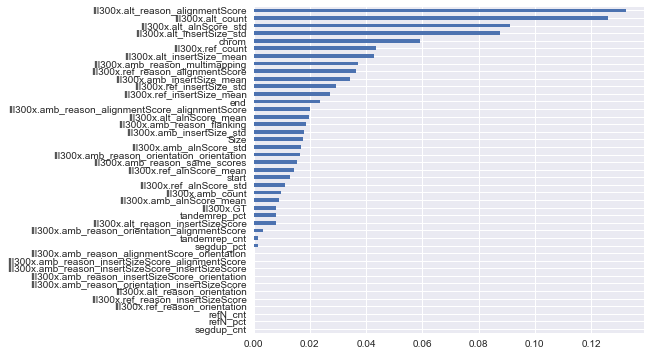

In [27]:
%matplotlib inline
feature_importances = pd.Series(model.feature_importances_, index=X_test.columns)
feature_importances.sort()
# feature_importances.plot.bar()
feature_importances.plot(kind="barh", figsize=(7,6))

In [28]:
#TODO: Try training the model with the most important features and note difference in overal model prediction score

<a id='prediction_step'></a>

In [29]:
model.predict(X_test)

array([ 0.,  0.,  1.,  1.,  2.,  2.,  2.,  0.,  2.,  0.,  2.,  0.,  1.,
        1.,  2.,  1.,  0.,  2.,  0.,  2.,  2.,  2.,  1.,  0.,  0.,  1.,
        1.,  1.,  2.,  1.,  1.,  1.,  0.,  2.,  1.,  1.,  0.,  2.,  0.,
        2.,  1.,  2.,  2.,  0.,  1.,  1.,  0.,  2.,  0.,  1.,  0.,  0.,
        1.,  2.,  1.,  2.,  0.,  2.,  0.,  1.,  1.,  1.,  1.,  2.,  0.,
        0.,  1.,  0.,  1.,  2.,  1.,  1.,  0.,  0.,  2.,  1.,  1.,  2.,
        1.,  0.,  1.,  1.,  2.,  2.,  0.,  1.,  2.,  1.,  0.,  2.,  0.,
        0.,  1.,  1.,  2.,  1.,  2.,  2.,  1.,  1.,  2.,  0.,  0.,  2.,
        0.,  1.,  1.,  2.,  2.,  2.,  0.,  2.,  2.,  2.,  1.,  1.,  2.,
        0.,  1.,  2.,  2.,  2.,  0.,  0.,  1.,  0.])

In [30]:
pred = model.predict(X_test)

<a id='poor_score1'></a>

In [31]:
print('Precision score of the training subset: {:.3f}'.format(precision_score(pred, y_test, average='micro'))) 

Precision score of the training subset: 0.690


In [32]:
# Add original labels and predicted labels back to the original dataframe
df_Xtest = pd.DataFrame(X_test)
df_Xtest.head()

,Ill300x.GT,Ill300x.alt_alnScore_mean,Ill300x.alt_alnScore_std,Ill300x.alt_count,Ill300x.alt_insertSize_mean,Ill300x.alt_insertSize_std,Ill300x.alt_reason_alignmentScore,Ill300x.alt_reason_insertSizeScore,Ill300x.alt_reason_orientation,Ill300x.amb_alnScore_mean,...,Size,chrom,end,refN_cnt,refN_pct,segdup_cnt,segdup_pct,start,tandemrep_cnt,tandemrep_pct
248,-1.0,586.000000,2.000000,2.0,1173.500000,10.500000,0.0,2.0,0.0,532.573541,...,-20.0,1.0,195540864.0,0.0,0.0,0.0,0.0,195540843.0,0.0,0.0
28,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,542.842009,...,-45.0,1.0,81643788.0,0.0,0.0,0.0,0.0,81643742.0,0.0,0.0
3,-1.0,573.655556,7.341149,180.0,582.988889,178.472562,177.0,3.0,0.0,539.861404,...,-25.0,15.0,77879888.0,0.0,0.0,0.0,0.0,77879862.0,0.0,0.0
176,1.0,571.258333,13.391848,120.0,586.958333,167.000918,119.0,1.0,0.0,521.281081,...,-37.0,11.0,9458906.0,0.0,0.0,0.0,0.0,9458868.0,0.0,0.0
209,1.0,580.015267,6.961162,131.0,561.221374,136.326633,130.0,1.0,0.0,538.261241,...,-25.0,13.0,90908532.0,0.0,0.0,0.0,0.0,90908506.0,0.0,0.0


In [33]:
labels = pd.DataFrame(y_test)

In [34]:
df_Xtest['predicted_label'] = pred
df_Xtest['GTcons'] = df_train['GTcons']
df_Xtest['ytest'] = ytest
df_Xtest['chrom'] = df_train['chrom']
df_Xtest['start'] = df_train['start']
df_Xtest['end'] = df_train['end']
# df_Xtest['Y_test'] = labels

In [35]:
df_Xtest.tail()

,Ill300x.GT,Ill300x.alt_alnScore_mean,Ill300x.alt_alnScore_std,Ill300x.alt_count,Ill300x.alt_insertSize_mean,Ill300x.alt_insertSize_std,Ill300x.alt_reason_alignmentScore,Ill300x.alt_reason_insertSizeScore,Ill300x.alt_reason_orientation,Ill300x.amb_alnScore_mean,...,refN_cnt,refN_pct,segdup_cnt,segdup_pct,start,tandemrep_cnt,tandemrep_pct,predicted_label,GTcons,ytest
269,-1.0,581.984127,2.853525,63.0,561.523809,155.191010,62.0,1.0,0.0,535.966475,...,0.0,0.0,0.0,0.0,14270726,1.0,1.000000,2.0,2,2.0
18,0.0,584.000000,4.000000,2.0,1232.500000,8.500000,0.0,2.0,0.0,536.305509,...,0.0,0.0,0.0,0.0,19374881,1.0,1.000000,0.0,0,0.0
64,0.0,554.500000,7.664855,4.0,453.250000,92.372547,4.0,0.0,0.0,530.557636,...,0.0,0.0,0.0,0.0,44211810,1.0,1.000000,0.0,0,0.0
276,1.0,584.914414,5.898303,222.0,567.972973,168.828313,219.0,3.0,0.0,534.430666,...,0.0,0.0,1.0,1.0,96806440,1.0,0.586207,1.0,2,2.0
65,0.0,565.000000,5.000000,2.0,1184.000000,11.000000,0.0,2.0,0.0,532.510884,...,0.0,0.0,0.0,0.0,56987207,2.0,0.687500,0.0,0,0.0


In [36]:
from sklearn.metrics import confusion_matrix
ytest = df_Xtest['GTcons']
predict = df_Xtest['predicted_label']
print(confusion_matrix(ytest, predict))

[[36  2  4]
 [ 0 27 15]
 [ 1 17 24]]


In [37]:
df_Xtest['GTcons'].replace(0.0, 'Homozygous_Reference', inplace=True)
df_Xtest['GTcons'].replace(1.0, 'Heterozygous_Variant', inplace=True)
df_Xtest['GTcons'].replace(2.0, 'Homozygous_Variant', inplace=True)
df_Xtest['predicted_label'].replace(0.0, 'Homozygous_Reference', inplace=True)
df_Xtest['predicted_label'].replace(1.0, 'Heterozygous_Variant', inplace=True)
df_Xtest['predicted_label'].replace(2.0, 'Homozygous_Variant', inplace=True)

In [38]:
pd.value_counts(df_Xtest['GTcons'].values, sort=False)

Heterozygous_Variant    42
Homozygous_Variant      42
Homozygous_Reference    42
dtype: int64

In [39]:
pd.value_counts(df_Xtest['predicted_label'].values, sort=False)

Heterozygous_Variant    46
Homozygous_Variant      43
Homozygous_Reference    37
dtype: int64

In [40]:
pd.crosstab(ytest, predict, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,Heterozygous_Variant,Homozygous_Reference,Homozygous_Variant,All
True,,,,
Heterozygous_Variant,27,0,15,42
Homozygous_Reference,2,36,4,42
Homozygous_Variant,17,1,24,42
All,46,37,43,126


In [41]:
from sklearn.metrics import classification_report
print(classification_report(ytest, predict))

                      precision    recall  f1-score   support

Heterozygous_Variant       0.59      0.64      0.61        42
Homozygous_Reference       0.97      0.86      0.91        42
  Homozygous_Variant       0.56      0.57      0.56        42

         avg / total       0.71      0.69      0.70       126



***
Predict
***

<a id='predict'></a>

Description:

   * In the [previous section](#machine_learning), a RF model was trained on svanalyzer data.

       * The model was trained using [train/test split](#train_test) where 70% of the data was used to train the model and the model performance was determined by predicting labels for the remaining 30% of the data
 * Reminder: The labels for this training set and the following [prediction step](#prediction_step) are the consensus genotype (GTcons) labels generated from a preliminary R analysis based on reference and alternate read count:
           * Homozygous Reference (0)
           * Heterozygous Variant (1)
           * Homozygous Variant (2)
           
   * The trained model is used in the following section to predict labels for 5000 randomly selected Deletions [these datapoints were randomly selected from [union_170509_refalt.sort.vcf](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_05092017/)]
   
   

** Load Data **

In [42]:
X2 = df_test

** Impute missing values using KNN **

In [43]:
#Convert dataframe to matrix
X2=X2.as_matrix()

#Imput missing values from three closest observations
X2_imputed=KNN(k=3).complete(X2)
X2=pd.DataFrame(X2_imputed)

Imputing row 1/3504 with 1 missing, elapsed time: 3.860
Imputing row 101/3504 with 2 missing, elapsed time: 3.869
Imputing row 201/3504 with 2 missing, elapsed time: 3.878
Imputing row 301/3504 with 2 missing, elapsed time: 3.886
Imputing row 401/3504 with 0 missing, elapsed time: 3.892
Imputing row 501/3504 with 2 missing, elapsed time: 3.902
Imputing row 601/3504 with 1 missing, elapsed time: 3.911
Imputing row 701/3504 with 2 missing, elapsed time: 3.918
Imputing row 801/3504 with 2 missing, elapsed time: 3.925
Imputing row 901/3504 with 1 missing, elapsed time: 3.931
Imputing row 1001/3504 with 0 missing, elapsed time: 3.938
Imputing row 1101/3504 with 2 missing, elapsed time: 3.946
Imputing row 1201/3504 with 0 missing, elapsed time: 3.953
Imputing row 1301/3504 with 2 missing, elapsed time: 3.959
Imputing row 1401/3504 with 0 missing, elapsed time: 3.966
Imputing row 1501/3504 with 2 missing, elapsed time: 3.973
Imputing row 1601/3504 with 2 missing, elapsed time: 3.980
Imputing 

In [44]:
dftest_header = list(df_test.columns.values)
X2.columns = dftest_header
X2.head(3)

,chrom,start,end,Size,refN_cnt,refN_pct,segdup_cnt,segdup_pct,tandemrep_cnt,tandemrep_pct,...,Ill300x.amb_reason_orientation_orientation,Ill300x.amb_reason_same_scores,Ill300x.ref_alnScore_mean,Ill300x.ref_alnScore_std,Ill300x.ref_count,Ill300x.ref_insertSize_mean,Ill300x.ref_insertSize_std,Ill300x.ref_reason_alignmentScore,Ill300x.ref_reason_insertSizeScore,Ill300x.ref_reason_orientation
0,4.0,95498964.0,95499280.0,-316.0,0.0,0.0,0.0,0.0,1.0,0.117089,...,5.0,71.0,588.000000,6.226494,13.0,831.000000,202.968357,13.0,0.0,0.0
1,19.0,14399929.0,14399954.0,-24.0,0.0,0.0,1.0,1.0,1.0,1.000000,...,4.0,141.0,584.039216,12.259387,102.0,541.176471,145.259431,102.0,0.0,0.0
2,8.0,76766532.0,76766569.0,-36.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,4.0,324.0,589.754546,7.642211,220.0,581.950000,134.929956,220.0,0.0,0.0


In [45]:
X3 = pd.DataFrame()
X3 = X2
X3.head(3)

,chrom,start,end,Size,refN_cnt,refN_pct,segdup_cnt,segdup_pct,tandemrep_cnt,tandemrep_pct,...,Ill300x.amb_reason_orientation_orientation,Ill300x.amb_reason_same_scores,Ill300x.ref_alnScore_mean,Ill300x.ref_alnScore_std,Ill300x.ref_count,Ill300x.ref_insertSize_mean,Ill300x.ref_insertSize_std,Ill300x.ref_reason_alignmentScore,Ill300x.ref_reason_insertSizeScore,Ill300x.ref_reason_orientation
0,4.0,95498964.0,95499280.0,-316.0,0.0,0.0,0.0,0.0,1.0,0.117089,...,5.0,71.0,588.000000,6.226494,13.0,831.000000,202.968357,13.0,0.0,0.0
1,19.0,14399929.0,14399954.0,-24.0,0.0,0.0,1.0,1.0,1.0,1.000000,...,4.0,141.0,584.039216,12.259387,102.0,541.176471,145.259431,102.0,0.0,0.0
2,8.0,76766532.0,76766569.0,-36.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,4.0,324.0,589.754546,7.642211,220.0,581.950000,134.929956,220.0,0.0,0.0


In [46]:
# Order features
X5 = X2.reindex_axis(sorted(X2.columns), axis=1)

In [47]:
model.predict(X5)

array([ 2.,  1.,  2., ...,  2.,  0.,  0.])

<a id='prediction_step'></a>

In [48]:
pred = model.predict(X5)

In [49]:
pred_prob = model.predict_proba(X5)

In [50]:
X5['predicted_label'] = pred
X5['chrom'] = df_test_2['chrom']
X5['start'] = df_test_2['start']
X5['end'] = df_test_2['end']
X5['Size'] = df_test_2['Size']
X5['GTcons'] = df_test_2['GTcons']
X5['GTsupp'] = df_test_2['GTsupp']

In [51]:
X6 = pd.concat([X5, pd.DataFrame(pred_prob, columns=['1','2','3'])])

In [52]:
X6.to_csv('300x_pred_prob_GTcons_DEL_SVanalyzer_balanced.csv', index=False)

In [ ]:
#Note: Reformat X6 csv

In [54]:
X6 = pd.read_csv('/Users/lmc2/NIST/Notebooks/SVanalyzer_ML/DEL/results/300x/300x_pred_prob_GTcons_DEL_SVanalyzer_balanced.csv')

In [55]:
X6.rename(columns={'1': 'Homozygous_Reference'}, inplace=True)
X6.rename(columns={'2': 'Heterozygous_Variant'}, inplace=True)
X6.rename(columns={'3': 'Homozygous_Variant'}, inplace=True)
X6.rename(columns={'predicted_label': '300x_predicted_label'}, inplace=True)

In [56]:
X6.head(3)

,Homozygous_Reference,Heterozygous_Variant,Homozygous_Variant,GTcons,GTsupp,Ill300x.GT,Ill300x.alt_alnScore_mean,Ill300x.alt_alnScore_std,Ill300x.alt_count,Ill300x.alt_insertSize_mean,...,chrom,end,300x_predicted_label,refN_cnt,refN_pct,segdup_cnt,segdup_pct,start,tandemrep_cnt,tandemrep_pct
0,0.0,0.3,0.7,2,1,-1,583.311364,10.419207,440,648.368182,...,4,95499280,2,0,0,0,0.0,95498964,1,0.117089
1,0.1,0.6,0.3,1,1,-1,580.656250,8.502240,32,546.468750,...,19,14399954,1,0,0,1,1.0,14399929,1,1.000000
2,0.2,0.1,0.7,1,2,1,581.966216,3.341822,148,585.952703,...,8,76766569,2,0,0,0,0.0,76766532,0,0.000000


In [ ]:
X6.to_csv('/Volumes/lesleydata/SVanalyzer_ML/Sept122017/Step3_ML/results/300x_final_GTcons_df_DEL_SVanalyzer_balanced.csv', index=False)

***
Label Analysis
***

Description:
  * The [random forest(RF) model](#train_test) was trained on svanalyzer data. The trained model was used to predict consensus GT labels for the 5000 deletions that were randomly selected from the union_refalt vcf. The following is a comparison of model predicted labels [Conesus GT] to consensus genotype generated by the R script for the 5000 randomly selected datapoints from union_refalt.vcf 

In [57]:
from sklearn.metrics import confusion_matrix
consensus_GT = X6['GTcons']
predict = X6['300x_predicted_label']
print(confusion_matrix(consensus_GT, predict))

[[ 795   53   73]
 [  39  767 1106]
 [   5  292  374]]


In [58]:
X6['GTcons'].replace(0, 'Homozygous_Reference', inplace=True)
X6['GTcons'].replace(1, 'Heterozygous_Variant', inplace=True)
X6['GTcons'].replace(2, 'Homozygous_Variant', inplace=True)
X6['300x_predicted_label'].replace(0.0, 'Homozygous_Reference', inplace=True)
X6['300x_predicted_label'].replace(1.0, 'Heterozygous_Variant', inplace=True)
X6['300x_predicted_label'].replace(2.0, 'Homozygous_Variant', inplace=True)

<a id='predictions'></a>

In [59]:
pd.crosstab(consensus_GT, predict, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,Heterozygous_Variant,Homozygous_Reference,Homozygous_Variant,All
True,,,,
Heterozygous_Variant,767,39,1106,1912
Homozygous_Reference,53,795,73,921
Homozygous_Variant,292,5,374,671
All,1112,839,1553,3504


In [60]:
print('Precision score of the prediction subset: {:.3f}'.format(precision_score(consensus_GT, predict, average='micro'))) 

Precision score of the prediction subset: 0.553


** High Confidence Label Analysis**
* **Reminder:** The labels predicted by the model are the following consensus genotype:
    * Homozygous Reference: 0 
    * Heterozygous Variant: 1 
    * Homozygous Variant: 2 
* Here **high confidence labels** are the labels predicted by the model that were also assigned a predict probability of either 0.9 or 1
* The following is an analysis of predicted svanalyzer labels with predict probability >0.9

In [61]:
high_conf_labels = X6[(X6['Homozygous_Reference'] == 1) | (X6['Homozygous_Reference'] == 0.9) | (X6['Heterozygous_Variant'] == 1) | (X6['Heterozygous_Variant'] == 0.9) | (X6['Homozygous_Variant'] == 1) | (X6['Homozygous_Variant'] == 0.9)]


In [62]:
consensus_GT = high_conf_labels['GTcons']
predict = high_conf_labels['300x_predicted_label']
pd.crosstab(consensus_GT, predict, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,Heterozygous_Variant,Homozygous_Reference,Homozygous_Variant,All
True,,,,
Heterozygous_Variant,30,1,79,110
Homozygous_Reference,1,400,1,402
Homozygous_Variant,18,0,35,53
All,49,401,115,565


In [63]:
from sklearn.metrics import classification_report
print(classification_report(consensus_GT, predict))

                      precision    recall  f1-score   support

Heterozygous_Variant       0.61      0.27      0.38       110
Homozygous_Reference       1.00      1.00      1.00       402
  Homozygous_Variant       0.30      0.66      0.42        53

         avg / total       0.86      0.82      0.82       565



***
Compare to crowdsourced results
***

#### 300X: Crowdsourced (Crowdvariant) Results
![Figure1](https://raw.githubusercontent.com/lesleymaraina/NIST/master/Notebooks/SVanalyzer_ML/DEL/images/300x_CrowdVar1.png)

![Figure1](https://raw.githubusercontent.com/lesleymaraina/NIST/master/Notebooks/SVanalyzer_ML/DEL/images/300x_CrowdVar2_.png)

![Figure1](https://raw.githubusercontent.com/lesleymaraina/NIST/master/Notebooks/SVanalyzer_ML/DEL/images/300x_CrowdVar3.png)